# Advanced dynamic seq2seq with TensorFlow

**UPDATE (16.02.2017)**: I learned some things after I writing this tutorial. In particular:
 - Replacing projection (one-hot encoding followed by linear layer) with embedding (indexing weights of linear layer directly) is more efficient.
 - When decoding, feeding previously generated tokens as inputs adds robustness to model's errors. However feeding ground truth speeds up training. Apperantly best practice is to mix both randomly when training.
I will update tutorial to reflect this at some point.

In [1]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [2]:
tf.__version__

'1.0.0'

In [3]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

Previously we elected to manually feed `decoder_inputs` to better understand what is going on. Here we implement decoder with `tf.nn.raw_rnn` and will construct `decoder_inputs` step by step in the loop.

## Projections

Here we manually setup input and output projections. It is necessary because we're implementing decoder with manual step transitions.

In [5]:
def projection(inputs, projection_size, scope):
    """
    Args:
        inputs: shape like [time, batch, input_size] or [batch, input_size]
        projection_size: int32
        scope: outer variable scope
    """
    input_size = inputs.get_shape()[-1].value 

    with tf.variable_scope(scope) as scope:
        W = tf.get_variable(name='W', shape=[input_size, projection_size],
                            dtype=tf.float32)

        b = tf.get_variable(name='b', shape=[projection_size],
                            dtype=tf.float32,
                            initializer=tf.constant_initializer(0, dtype=tf.float32))

    input_shape = tf.unstack(tf.shape(inputs))

    if len(input_shape) == 3:
        time, batch, _ = input_shape  # dynamic parts of shape
        inputs = tf.reshape(inputs, [-1, input_size])

    elif len(input_shape) == 2:
        batch, _depth = input_shape

    else:
        raise ValueError("Wierd input shape: {}".format(inputs))

    linear = tf.add(tf.matmul(inputs, W), b)

    if len(input_shape) == 3:
        linear = tf.reshape(linear, [time, batch, projection_size])

    return linear

## Encoder

We are replacing unidirectional `tf.nn.dynamic_rnn` with `tf.nn.bidirectional_dynamic_rnn` as the encoder.


In [6]:
from tensorflow.contrib.rnn import (LSTMCell, LSTMStateTuple,
                                    InputProjectionWrapper,
                                    OutputProjectionWrapper)

In [7]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [8]:
with tf.variable_scope('EncoderInputProjection') as scope:
    encoder_inputs_onehot = tf.one_hot(encoder_inputs, vocab_size)
    encoder_inputs_projected = projection(encoder_inputs_onehot, input_embedding_size, scope)

In [9]:
encoder_inputs_projected

<tf.Tensor 'EncoderInputProjection/Reshape_1:0' shape=(?, ?, 20) dtype=float32>

In [10]:
((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_projected,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

In [11]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [12]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [13]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [14]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

Have to concatenate forward and backward outputs and state. In this case we will not discard outputs, they would be used for attention.

In [16]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_fw_outputs), 2)

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

In [17]:
## - encoder override with forward-only rnn
# with tf.variable_scope('encoder_override'):
#     encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
#         cell=encoder_cell,
#         inputs=encoder_inputs_projected,
#         dtype=tf.float32, time_major=True,
#     )

## Decoder

In [18]:
decoder_cell = LSTMCell(decoder_hidden_units)

In [19]:
# time and batch dimensions are dynamic, i.e. they can change in runtime, from batch to batch
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

# how far to run the decoder is our decision
decoder_lengths = encoder_inputs_length + 3
# +2 additional steps, +1 leading <EOS> token for decoder inputs

Decoder without projection.
Internal transition step uses greedy search:
```
output(t) -> output projection(t) -> prediction(t) (argmax) -> input projection(t+1) -> next input(t+1)
```

### Decoder via `tf.nn.raw_rnn`

`tf.nn.dynamic_rnn` allows for easy RNN construction, but is limited. For example, a nice way to increase robustness of the model is to feed as decoder inputs tokens that it previously generated, instead of shifted true sequence.

![seq2seq-feed-previous](pictures/2-seq2seq-feed-previous.png)
*Image borrowed from http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/*

In [20]:
assert EOS == 1
assert PAD == 0

eos_time_slice = tf.one_hot(
    tf.ones([batch_size], 
            dtype=tf.int32, name='EOS'), 
    vocab_size, name='EOS_OneHot')

pad_time_slice = tf.one_hot(
    tf.zeros([batch_size], 
             dtype=tf.int32, name='PAD'),
    vocab_size, name='PAD_OneHot')

def loop_fn_initial(time, cell_output, cell_state, loop_state):
    assert cell_output is None and loop_state is None and cell_state is None

    elements_finished = (time >= decoder_lengths)  # all True at the 1st step
    with tf.variable_scope('DecoderInputProjection') as scope:
        initial_input = projection(eos_time_slice, input_embedding_size, scope)
    initial_cell_state = encoder_final_state
    initial_loop_state = None  # we don't need to pass any additional information
    
    return (elements_finished,
            initial_input,
            initial_cell_state,
            None,  # cell output is dummy here
            initial_loop_state)

def loop_fn(time, cell_output, cell_state, loop_state):
    """ loop_fn determines transitions between RNN unroll steps
    """

    if cell_state is None:    # time == 0
        return loop_fn_initial(time, cell_output, cell_state, loop_state)
    
    emit_output = cell_output  # == None for time == 0

    next_cell_state = cell_state

    elements_finished = (time >= decoder_lengths)
    finished = tf.reduce_all(elements_finished)

    def padded_next_input():
        with tf.variable_scope('DecoderInputProjection', reuse=True) as scope:
            return projection(pad_time_slice, input_embedding_size, scope)
        
    def search_for_next_input():
        """ output->input transition:

            output[t] -> output projection[t] -> prediction[t] ->
            -> input[t+1] -> input projection[t+1]
        """
        with tf.variable_scope('DecoderOutputProjection') as scope:
            output = projection(cell_output, vocab_size, scope)
        prediction = tf.argmax(output, axis=1)
        prediction_onehot = tf.one_hot(prediction, vocab_size)
        with tf.variable_scope('DecoderInputProjection', reuse=True) as scope:
            projection_ = projection(prediction_onehot, input_embedding_size, scope)
        return projection_
    
    next_input = tf.cond(finished, padded_next_input, search_for_next_input)

    next_loop_state = None

    result = (elements_finished, 
            next_input, 
            next_cell_state,
            emit_output,
            next_loop_state)
    
    return result

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

with tf.variable_scope('DecoderOutputProjection') as scope:
    decoder_logits = projection(decoder_outputs, vocab_size, scope)

decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer

RNN outputs tensor of shape `[max_time, batch_size, hidden_units]` which projection layer maps onto `[max_time, batch_size, vocab_size]`. `vocab_size` part of the shape is static, while `max_time` and `batch_size` is dynamic.

In [21]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [22]:
sess.run(tf.global_variables_initializer())

## Training on the toy task

Consider the copy task — given a random sequence of integers from a `vocabulary`, learn to memorize and reproduce input sequence. Because sequences are random, they do not contain any structure, unlike natural language.

In [23]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[8, 9, 6, 8, 2, 4, 2, 4]
[7, 3, 3, 5, 8]
[6, 3, 7, 5, 7, 9]
[5, 7, 3, 9, 5, 9, 9, 4]
[3, 7, 9, 9, 5, 8]
[9, 4, 4]
[7, 3, 2, 3]
[2, 8, 3, 7, 2, 5]
[6, 2, 7, 9, 8, 4, 4]
[9, 3, 9, 9, 6, 3]


In [24]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [25]:
loss_track = []

In [26]:
max_batches = 10000
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.2984840869903564
  sample 1:
    input     > [5 3 4 0 0 0 0 0]
    predicted > [8 0 0 0 0 0 0 0 0 0 0]
  sample 2:
    input     > [3 2 5 2 5 6 7 7]
    predicted > [7 0 0 0 0 0 0 0 3 0 0]
  sample 3:
    input     > [2 4 4 6 0 0 0 0]
    predicted > [7 7 0 0 3 0 0 0 0 0 0]

batch 1000
  minibatch loss: 0.60413658618927
  sample 1:
    input     > [4 7 7 9 3 0 0 0]
    predicted > [4 7 7 7 3 1 0 0 0 0 0]
  sample 2:
    input     > [8 5 4 9 3 0 0 0]
    predicted > [8 5 9 9 3 1 0 0 0 0 0]
  sample 3:
    input     > [2 8 9 0 0 0 0 0]
    predicted > [2 8 9 1 0 0 0 0 0 0 0]

batch 2000
  minibatch loss: 0.2828637659549713
  sample 1:
    input     > [8 2 4 0 0 0 0 0]
    predicted > [8 2 4 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [9 2 3 0 0 0 0 0]
    predicted > [9 2 3 1 0 0 0 0 0 0 0]
  sample 3:
    input     > [3 5 4 4 8 2 8 9]
    predicted > [3 5 4 4 4 8 8 9 1 0 0]

batch 3000
  minibatch loss: 0.1508026272058487
  sample 1:
    input     > [7 7 2 3

loss 0.0120 after 1000000 examples (batch_size=100)


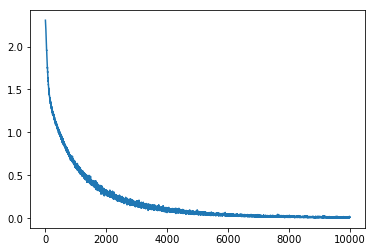

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))